In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [4]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from qiskit import *
from qiskit.circuit.library import ZZFeatureMap 
from qiskit.primitives import Sampler as QiskitSampler
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

In [6]:
from sklearn.svm import SVC
n_feat = 8
n_train = 1000
n_test = 500

#train_index = [0:200]
#test_index = [0:50]

# Data Preparing

In [7]:
from os import listdir
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch


def data_load_and_process(dataset, n_feature, classes=[0,1]):

    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'cifar100':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
        
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0

    if len(classes) ==2:
        train_filter_tf = np.where((y_train == classes[0] ) | (y_train == classes[1] ))
        test_filter_tf = np.where((y_test == classes[0] ) | (y_test == classes[1] ))
 

    x_train, y_train = x_train[train_filter_tf], y_train[train_filter_tf]
    x_test, y_test = x_test[test_filter_tf], y_test[test_filter_tf]


    x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
    x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
    x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()
    X_train = PCA(n_feature).fit_transform(x_train)
    X_test = PCA(n_feature).fit_transform(x_test)
    x_train, x_test = [], []
    for x in X_train:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_train.append(x)
    for x in X_test:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_test.append(x)
    return x_train, x_test, y_train, y_test

In [8]:
X_train, X_test, Y_train, Y_test = data_load_and_process(dataset='cifar100', n_feature=n_feat, classes=[3,88])

169001437/169001437 [==============================] - 48s 0us/step


In [9]:
X_train, Y_train = X_train[1:1000], Y_train[1:1000]
X_test, Y_test = X_test[1:500], Y_test[1:500]
print(X_train)

[array([0.       , 3.1415927, 2.437769 , 2.6011865, 3.139578 , 2.7235413,
       2.7376626, 2.7093809], dtype=float32), array([2.562155  , 0.        , 2.4213455 , 0.01376799, 0.8388987 ,
       3.1415927 , 1.9036556 , 2.7706974 ], dtype=float32), array([3.1415925 , 0.16761531, 0.        , 0.11988027, 0.05752938,
       0.04306436, 0.03737964, 0.09291119], dtype=float32), array([3.1415927 , 0.        , 0.1426746 , 0.8551768 , 0.25329462,
       0.18448271, 0.25778207, 0.3528644 ], dtype=float32), array([3.1415925 , 0.10987447, 0.15744956, 0.08064361, 0.10611445,
       0.        , 0.03724262, 0.03703386], dtype=float32), array([3.1415927 , 0.85110766, 1.4731109 , 1.3747995 , 0.577709  ,
       0.08906873, 0.55569184, 0.        ], dtype=float32), array([3.1415925 , 0.96748793, 0.        , 0.32036856, 0.6352046 ,
       0.8375202 , 0.54163855, 0.701819  ], dtype=float32), array([1.0002384, 0.       , 3.1415927, 2.7789965, 2.9324975, 2.0876784,
       3.0405507, 2.6800811], dtype=float32),

In [10]:
import collections, numpy
counter = collections.Counter(Y_train)
counter2 = collections.Counter(Y_test)
print("Number of data each class in Training set:")
print(counter)
print("Number of data each class in Test set:")
print(counter2)

Number of data each class in Training set:
Counter({3: 500, 88: 499})
Number of data each class in Test set:
Counter({88: 100, 3: 99})


# 1. Classical SVC

In [11]:
svc_cl = SVC()
svc_cl.fit(X_train, Y_train)
score_test_cl = svc_cl.score(X_test, Y_test)

print(score_test_cl)
print(svc_cl.predict(X_test))
print(Y_test)

0.5879396984924623
[ 3  3  3 88 88  3  3 88 88  3  3  3  3 88 88  3  3  3 88  3  3 88  3 88
 88 88 88  3 88  3  3 88 88 88  3 88 88 88 88 88 88  3 88  3 88 88 88  3
 88  3  3  3  3 88 88  3 88 88 88  3 88 88 88 88 88 88 88  3  3 88  3 88
  3 88  3  3  3 88 88 88  3  3  3 88 88  3  3 88 88  3 88  3 88  3  3  3
  3  3  3 88 88 88  3 88 88 88  3 88  3  3 88 88 88 88 88  3 88  3  3 88
  3 88  3 88 88 88 88 88 88  3 88 88 88 88 88 88  3 88 88  3  3 88  3  3
  3  3 88 88  3 88  3  3 88 88  3  3 88  3  3 88  3  3  3 88 88 88 88  3
 88 88 88 88  3 88  3 88  3 88 88 88 88 88 88 88 88 88 88 88  3 88 88 88
  3  3  3  3  3  3  3]
[ 3 88  3 88  3  3 88 88 88  3 88 88 88  3  3  3  3 88 88 88 88  3 88  3
 88 88  3  3  3  3  3 88  3 88  3  3  3 88 88 88  3 88 88  3  3  3 88  3
  3  3 88  3 88  3 88 88  3 88 88 88 88  3 88  3  3 88  3 88 88 88  3  3
  3 88 88  3  3 88 88  3 88  3  3 88 88 88  3  3 88  3  3 88  3 88  3 88
  3  3 88  3 88  3  3 88 88 88  3 88 88  3  3 88  3 88 88  3 88  3 88 88
  3 88  3

In [12]:
y_pred=svc_cl.predict(X_test)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, y_pred)
cm

array([[52, 47],
       [35, 65]])

# 2. Quantum Kernel Method (QSVC)

In [13]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=n_feat, reps=3, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [14]:
qsvc = SVC(kernel=adhoc_kernel.evaluate)

qsvc.fit(X_train, Y_train)
score = qsvc.score(X_test, Y_test)
print(score)
print(qsvc.predict(X_test))
print(Y_test)

KeyboardInterrupt: 

In [13]:
y_pred=qsvc.predict(X_test)

# 2. Use Classical ML to improve Quantum Kernel

In [15]:
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    return X1_new, X2_new, Y_new

X1_new_valid, X2_new_valid, Y_new_valid = new_data(10, X_test, Y_test)

/tmp/ipykernel_139024/1358756659.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


In [16]:
pip install pennylane==0.27.0


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pennylane as qml
from pennylane import numpy as np

N_layers = 3

# exp(ixZ) gate
def exp_Z(x, wires, inverse=False):
    if inverse == False:
        qml.RZ(-2 * x, wires=wires)
    elif inverse == True:
        qml.RZ(2 * x, wires=wires)

# exp(i(pi - x1)(pi - x2)ZZ) gate
def exp_ZZ2(x1, x2, wires, inverse=False):
    if inverse == False:
        qml.CNOT(wires=wires)
        qml.RZ(-2 * (np.pi - x1) * (np.pi - x2), wires=wires[1])
        qml.CNOT(wires=wires)
    elif inverse == True:
        qml.CNOT(wires=wires)
        qml.RZ(2 * (np.pi - x1) * (np.pi - x2), wires=wires[1])
        qml.CNOT(wires=wires)


# Quantum Embedding 1 for model 1 (Conventional ZZ feature embedding)
def QuantumEmbedding1(input):
    for i in range(N_layers):
        for j in range(n_feat):
            qml.Hadamard(wires=j)
            exp_Z(input[j], wires=j)
        for k in range(n_feat-1):
            exp_ZZ2(input[k], input[k+1], wires=[k,k+1])
        exp_ZZ2(input[n_feat-1], input[0], wires=[n_feat-1, 0])

def QuantumEmbedding1_inverse(input):
    for i in range(N_layers):
        exp_ZZ2(input[n_feat-1], input[0], wires=[n_feat-1, 0], inverse=True)
        for k in reversed(range(n_feat-1)):
            exp_ZZ2(input[k], input[k+1], wires=[k,k+1], inverse=True)
        qml.Barrier()
        for j in range(n_feat):
            exp_Z(input[j], wires=j, inverse=True)
            qml.Hadamard(wires=j)

dev = qml.device('default.qubit', wires=n_feat)

@qml.qnode(dev, interface="torch")
def circuit1(inputs): 
    QuantumEmbedding1(inputs[0:n_feat])
    QuantumEmbedding1_inverse(inputs[n_feat:2 * n_feat])
    return qml.probs(wires=range(n_feat))

In [19]:
from torch import nn
class Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(circuit1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(n_feat, 2 * n_feat),
            nn.ReLU(),
            nn.Linear(2 * n_feat, 2 * n_feat),
            nn.ReLU(),
            nn.Linear(2 * n_feat, n_feat)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

model = Model1_Fidelity()

In [20]:
# Define model, optimizer, and loss function
loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
train_loss=[]
# Start training

loss_list = []  # Store loss history
model.train()  # Set model to training mode

iterations = 1000
for it in range(iterations):
    X1_batch, X2_batch, Y_batch = new_data(10, X_train, Y_train)
    pred = model(X1_batch, X2_batch)
    loss = loss_fn(pred, Y_batch)
    train_loss.append(loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if it % 10 == 0:
        print(f"Iterations: {it} Loss: {loss.item()}")
        with torch.no_grad():
            pred_validation = model(X1_new_valid, X2_new_valid)
            loss_validation = loss_fn(pred_validation, Y_new_valid)
            print(f"Validation Loss: {loss_validation}")

Iterations: 0 Loss: 0.6048051714897156
Validation Loss: 0.32249850034713745
Iterations: 10 Loss: 0.22870346903800964
Validation Loss: 0.3090289831161499
Iterations: 20 Loss: 0.4043004512786865
Validation Loss: 0.3072877526283264
Iterations: 30 Loss: 0.3294556736946106
Validation Loss: 0.2873195707798004
Iterations: 40 Loss: 0.38412150740623474
Validation Loss: 0.3176613748073578
Iterations: 50 Loss: 0.38010209798812866
Validation Loss: 0.30482956767082214
Iterations: 60 Loss: 0.1694934070110321
Validation Loss: 0.2464381754398346
Iterations: 70 Loss: 0.3158872425556183
Validation Loss: 0.31701573729515076
Iterations: 80 Loss: 0.3823562264442444
Validation Loss: 0.2741684317588806
Iterations: 90 Loss: 0.22752070426940918
Validation Loss: 0.261821985244751
Iterations: 100 Loss: 0.265900194644928
Validation Loss: 0.28424105048179626
Iterations: 110 Loss: 0.363206148147583
Validation Loss: 0.332866907119751
Iterations: 120 Loss: 0.3924907445907593
Validation Loss: 0.3392125964164734
Iterat

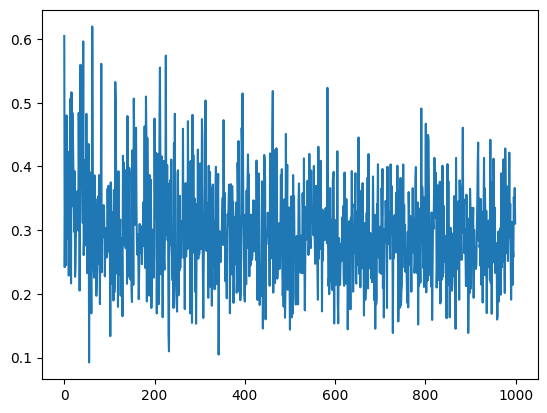

In [21]:
plt.plot(train_loss)

In [22]:
torch.save(model.state_dict(), 'Model1.pt')

In [23]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(n_feat, 2 * n_feat),
            nn.ReLU(),
            nn.Linear(2 * n_feat, 2 * n_feat),
            nn.ReLU(),
            nn.Linear(2 * n_feat, n_feat)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x

model = x_transform()

In [24]:
model.load_state_dict(torch.load('Model1.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
X_train = torch.tensor(X_train).to(torch.float32)
X_test = torch.tensor(X_test).to(torch.float32)

In [26]:
X_train = model(X_train)
X_test = model(X_test)

In [ ]:
X_train = X_train.detach().numpy()
X_test = X_test.detach().numpy()

qsvc = SVC(kernel=adhoc_kernel.evaluate)

qsvc.fit(X_train, Y_train)
score = qsvc.score(X_test, Y_test)
y_pred=qsvc.predict(X_test)
print(score)
print(qsvc.predict(X_test))
print(Y_test)

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,accuracy_score,ConfusionMatrixDisplay

cm=confusion_matrix(Y_test,qsvc.predict(X_test))
cm

array([[18, 10],
       [11, 10]])

In [27]:
print(train_loss)

[0.5413883328437805, 0.57728111743927, 0.576746940612793, 0.3979824185371399, 0.6265405416488647, 0.49186745285987854, 0.4884592890739441, 0.3638244569301605, 0.5182387232780457, 0.41787928342819214, 0.28089261054992676, 0.29676055908203125, 0.4321816861629486, 0.4583466947078705, 0.3032187819480896, 0.32059770822525024, 0.5408027768135071, 0.39817675948143005, 0.3471826910972595, 0.29552900791168213, 0.42510277032852173, 0.2993491590023041, 0.3454815149307251, 0.44858318567276, 0.4535483717918396, 0.2972714304924011, 0.31151247024536133, 0.4737057685852051, 0.2025769054889679, 0.2209416627883911, 0.2936117649078369, 0.5260540843009949, 0.32603153586387634, 0.2896064817905426, 0.38569337129592896, 0.14317628741264343, 0.43956947326660156, 0.6135157346725464, 0.31448185443878174, 0.19140763580799103, 0.19471487402915955, 0.553517758846283, 0.29068702459335327, 0.14085710048675537, 0.2840197682380676, 0.1758216917514801, 0.3579031825065613, 0.2538984715938568, 0.37887388467788696, 0.4672

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=n_feat, reps=3, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [ ]:
from functools import reduce
def data_map_eq10_ori(x, gamma):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.exp(-gamma*((m - n)*(m - n))), x)
    return coeff

In [ ]:
from qiskit.utils import QuantumInstance
sv_qi = QuantumInstance(
  BasicAer.get_backend("statevector_simulator")
)

In [ ]:
#QSVC WITH HYPERPARAMETER TUNNING
import time
from itertools import product
import statistics
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=5)
# Define the hyperparameters to search over
#gamma_values = [ 0.00001, 0.0001, 0.001, 0.01, 0.1, 1,10,100,500,1000] 
#C_values = ['scale',0.00001, 0.0001, 0.001, 0.01, 0.1, 1,10,100,500,1000]
n_features = n_feat
scale_gamma= 1 / (n_feat * X_train.var())
#C_values = [0.1, 1, 10, 100, 1000]
#gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]
C_values = [0.1, 1, 3, 5,7,8,10,50, 100, 1000]
gamma_values = [ scale_gamma/100,scale_gamma/10,scale_gamma ,scale_gamma*0.5,scale_gamma*10,1, 0.1, 0.01, 0.001, 0.0001]


#gamma_values =[20,25]
#C_values = [1,2]

feature_dim = n_feat

best_f1 = 0.0
best_gamma = None
best_C = None
start_time = time.time()

for gamma_val, C_val in product(gamma_values, C_values):
    data_map_func_rbf = lambda x: data_map_eq10_ori(x, gamma_val)
    feature_map_ori = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear", data_map_func=data_map_func_rbf)
    previous_kernel = QuantumKernel(feature_map=feature_map_ori, quantum_instance=sv_qi)
  #  print(lambda x: data_map_eq10_ori(x, gamma))
#qsvc = QSVC(quantum_kernel=previous_kernel, C=1, gamma=gamma)
    qsvc = QSVC(quantum_kernel=previous_kernel, C=C_val)
    
#Cross Validation
   
    F1_num = []
    for i, (train_index, val_index) in enumerate(skf.split(X_train,Y_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index] 
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index] 

# Train the QSVC classifier
        qsvc.fit(X_train_fold, Y_train_fold)

# Predict the labels for the test data
        predicted_labels = qsvc.predict(X_val_fold)

#F1_Score Calculation   
        
        F1_num.append(f1_score(Y_val_fold, predicted_labels))
   # print("F1 Score:", f1)
# Calculate accuracy
   # accuracy = qsvc.score(X_test, y_test)
        print(f"Fold {i}:")
        print("gamma:", gamma_val,"C:", C_val,"F1:", F1_num)
    

    # Track the best hyperparameters
    sum1 = sum(F1_num)
    avg_F1 = statistics.mean(F1_num)
    if  avg_F1 > best_f1:
        best_f1 = avg_F1
        best_gamma = gamma_val
        best_C = C_val

# Print the best hyperparameters and accuracy
print("Best gamma:", best_gamma)
print("Best C:", best_C)
print("Best F1:",best_f1)

end_time = time.time()
execution_time = end_time - start_time

print("Total execution time:", execution_time, "seconds")


In [ ]:
#QSVM using best gamma and C by rbf kernel

gamma = best_gamma
data_map_func_rbf = lambda x: data_map_eq10_ori(x, gamma)
feature_map_ori = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear", data_map_func=data_map_func_rbf)
previous_kernel = QuantumKernel(feature_map=feature_map_ori, quantum_instance=sv_qi)

qsvc = QSVC(quantum_kernel=previous_kernel, C=best_C)


# Train the QSVC classifier
qsvc.fit(X_train, Y_train)

# Predict the labels for the test data
predicted_labels = qsvc.predict(X_test)

# Evaluate the classification accuracy
qsvc_score = qsvc.score(X_test, Y_test)

print(f"QSVC classification test score: {qsvc_score}")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print("QSVM result:\n")
print(classification_report(Y_test, predicted_labels))
print("F1 :",f1_score(Y_test, predicted_labels))